# Mixture of Experts
Implementation of Mixture of Experts for Regression  
Amirabbas Asadi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Generating Sample Data

First we generate a simple regression dataset

In [2]:
from sklearn.preprocessing import StandardScaler
coeffs = np.array([[0.75, 2.0], [6.0, 5.0], [-2.0, -3.0]])
n = 100
dim = 1
x = np.linspace(-2, 2, n)
X = np.array([[x+4*i] for i in range(len(coeffs))]).reshape(-1, dim)
y = np.array([a*x+b+np.random.normal(size=n) for a,b in coeffs]).reshape(-1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.hstack((np.ones(len(X)).reshape(-1, 1), X))

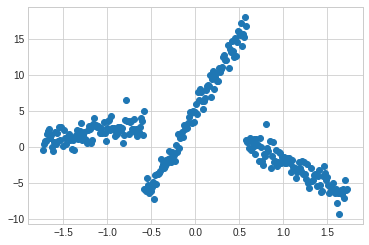

In [3]:
_ = plt.scatter(X[:, 1:].reshape(-1), y)

## Model Specifications
A mixture of experts is a latent variable model that for regression task can be defined as follows:  

$$p(y_i|x_i, z_i=k, \theta) = \mathcal{N}(y_i|w^T_kx_i, \sigma_k^2)$$

$$p(z_i|x_i) = Cat(z_i|\mathcal{S}(V^Tx_i))$$

See the reference [1] for more details.

## Initialize Parameters

Weights, Gating parameters and latent variables are initialized randomly

In [4]:
from sklearn.preprocessing import normalize

def softmax(x):
   ex = np.exp(x)
   return ex/ex.sum(axis=1).reshape((-1, 1))

# number of expert models
experts = 3
N = len(X)
reg_dim = dim + 1
# initial random weights
W = np.random.normal(size=(experts, reg_dim))
# initial random gates
V = np.random.normal(size=(dim, experts))
sigma = np.ones(experts)
pi = np.random.uniform(size=(N, experts))
pi = normalize(pi, norm='l1', axis=1)
r = np.ones_like(pi)

## Expectation Maximization

Since this is a latent variable model we can use Expectation Maximization algorithm to estimate the parameters.

### E Step

In E step we estimate the latent variables given the parameters.  

$$ r_{ik} \propto \pi^{old}_{ik} \mathcal{N}(y_i|x_i^Tw_k^{old}, (\sigma_k^{old})^2) $$


In [5]:
from scipy.stats import norm

def mix_experts_e_step():
  global r

  for i, item in enumerate(X):
    for k in range(experts):
      r[i, k] = pi[i, k] * norm.pdf(y[i], loc=np.dot(W[k].T, X[i]), scale=sigma[k])

  r = normalize(r, norm='l1', axis=1)

### M Step

In M step we optimize the parameters given the latent variables obtained in E step.  
The $W$ can be estimated by solving a weighted least squares problem:  
$$ w_k = (X^TR_kX)^{-1}X^TR_kXy $$ 
Where $R_k = diag(r_{:,k})$. The variance is updated as follows:  

$$ \sigma^2 = \frac{\sum_{i=1}^Nr_{ik}(y_i - w_k^Tx_i)^2}{\sum_{i=1}^Nr_{ik}} $$

The loss function for updating $V$ is:  

$$ \mathcal{l}(V) = \sum_i\sum_kr_{ik} \log{\mathcal{S}(V^Tx_i)_k} $$

Hence to update the $V$ we should train a logistic regression with soft targets $r$.

#### Soft Target Logistic Regression
To update $V$ Matrix in M-Step we need a Logistic Regression model supporting soft labels. 

In [6]:
import jax.numpy as jnp
from jax import grad, jit

class SoftLogisticRegression():
  def loss(self, W):
    pred = jnp.dot(self.D, W)
    pred = jnp.exp(pred)
    pred /= pred.sum(axis=1).reshape(-1, 1)
    pred = jnp.log(pred)
    pred *= self.Y
    return -pred.sum()
  def fit(self, X, y):
      targets = y.shape[1]
      dim = X.shape[1]
      g = jit(grad(jit(self.loss)))
      # initilalize parameters
      Wj = jnp.asarray(np.random.uniform(size=(dim, targets)))
      self.Y = jnp.asarray(y)
      self.D = jnp.asarray(X)
      self.W = None
      max_iters = 2000
      lr = 1e-3
      eps = 1e-4
      for i in range(max_iters):
        dir = -g(Wj)
        Wj += lr * dir
        # stop at convergence
        if(jnp.linalg.norm(dir) < eps):
          break
      self.W = np.array(Wj)

### Maximizing the lower bound of log-likelihood

In [7]:
from sklearn.linear_model import LinearRegression

softlr = SoftLogisticRegression()
lr = LinearRegression(fit_intercept=False)

def mix_experts_m_step():
  global W, V, pi, lr
  # update weights
  for k in range(experts):
    lr.fit(X, y, sample_weight=r[:, k])
    W[k] = lr.coef_

  # update sigma
  for k in range(experts):
    sigma[k] = 0
    for i, item in enumerate(X):
      sigma[k] += r[i, k] * (y[i] - np.dot(W[k].T, X[i]))**2
    sigma[k] /= r[:, k].sum()
    sigma[k] = np.sqrt(sigma[k])

   
  # update gating parameters
  softlr.fit(X[:, 1:], r)
  V = softlr.W
  pi = softmax(np.dot(X[:, 1:], V))

### Estimated log-likelihood

In [8]:
# Estimating Log-likelihood
def elbo():
  ll = 0
  for i, item in enumerate(X):
    for k in range(experts):
      ll += r[i, k] * np.log(1e-10 + pi[i, k] * norm.pdf(y[i],
                                                 loc=np.dot(W[k].T, X[i]),
                                                 scale=sigma[k]))    
  return ll
print("Estimating Log-likelihood : ", elbo())

Estimating Log-likelihood :  -8480.696818388575


## Training

In [9]:
from tqdm.notebook import tqdm

max_iters = 100
eps = 0.1
pbar = tqdm(range(max_iters))
ll = [elbo()]
for i in pbar:
  pbar.set_description('ELBO : {:.3f}'.format(ll[-1]))
  mix_experts_e_step()
  mix_experts_m_step()
  ll.append(elbo())
  pbar.set_description('ELBO : {:.3f}'.format(ll[-1]))
  # check for convergence
  if(np.abs(ll[-1] - ll[-2]) < eps):
    break
  pbar.update(1)

## Visualization

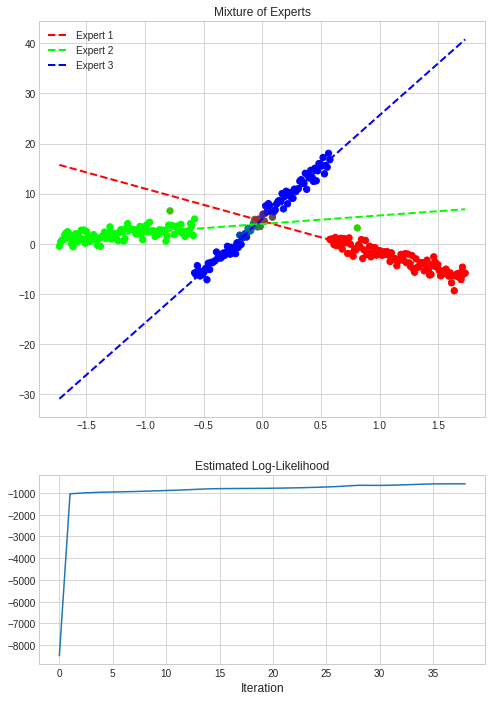

In [10]:
fig = plt.figure(figsize=(8,16))
ax1 = fig.add_subplot(211)
c = np.eye(3)
ax1.scatter(X[:, 1:].reshape(-1), y, c=r, s=40)

for k in range(experts):
  _ = ax1.plot(X[:, 1], np.dot(X, W[k]),
              c=c[k], label="Expert {}".format(k+1), ls='dashed', lw=2)
  _ = ax1.legend(prop={'size': 10})

ax1.set_title('Mixture of Experts')
ax2 = fig.add_subplot(413)
ax2.plot(ll)
ax2.set_title('Estimated Log-Likelihood')
ax2.set_xlabel('Iteration', fontsize=12)
plt.show()

## References
- [1] Machine Learning a Probabilistic Perspective, Kevin P. Murphy, The MIT Press 2012, Chapter 11, Sections 11.2.4 and 11.4.3
- [2] Hierarchical Mixtures of Experts and the EM algorithm, Micheal I. Jordan, Robert A. Jacobs, Proceedings of 1993 International  Joint Conference on Neural Networks 